In [26]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

In [2]:
filename = 'Datasets/final_imit_spec.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(1056, 120, 128, 128, 3)
(264, 120, 128, 128, 3)
(1056, 1482)
(264, 1482)
(1056,)
(264,)


In [3]:
# filename = 'Datasets/final_native_spec.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# native_train_images, native_test_images, native_y_train, native_y_test, native_env_train, native_env_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(len(native_train_images))
# print(len(native_test_images))
# print(native_y_train.shape)
# print(native_y_test.shape)
# print(native_env_train.shape)
# print(native_env_test.shape)

##### STA LTA

In [4]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [5]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

### Visualize

In [6]:
# idx = 3
# plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
# plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
# fig = plt.gcf()
# fig.set_size_inches(12,6)
# plt.xticks(fontsize=19)
# plt.yticks(fontsize=19)
# plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
# plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# # plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [7]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [8]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

1673

In [9]:
num_class = 19

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [12]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(1056, 120)
(264, 120)
(1056, 120)
(264, 120)
(1056, 120, 19)
(264, 120, 19)


In [13]:
x3train, y3train = masker(imit_train_images, y_down_train, mask_down_train)
x3test, y3test = masker(imit_test_images, y_down_test, mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(6202,)
(6202,)
(1551,)
(1551,)


In [14]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 1300,
         2: 611,
         0: 452,
         3: 990,
         16: 193,
         17: 186,
         18: 205,
         13: 195,
         14: 210,
         15: 232,
         4: 200,
         5: 153,
         6: 150,
         10: 195,
         11: 175,
         12: 180,
         7: 180,
         8: 199,
         9: 196})

In [15]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(5750,)
(5750,)
(1425,)
(1425,)


## RD - RA

In [16]:
filename = 'Datasets/final_imit_RD-RA2.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_y_train_RD.shape)
print(imit_y_test_RD.shape)
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)
del x

(1056, 605)
(264, 605)
(1056, 605, 64, 64, 3)
(1056, 605, 64, 64, 3)
(264, 605, 64, 64, 3)
(264, 605, 64, 64, 3)


In [17]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(1056, 120, 5, 64, 64, 3)
(1056, 120, 19)
(264, 120, 5, 64, 64, 3)
(264, 120, 19)
(1056, 120, 5, 64, 64, 3)
(264, 120, 5, 64, 64, 3)


In [18]:
x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(6202,)
(6202,)
(1551,)
(1551,)
(6202,)
(1551,)


In [19]:
y1train[0].shape

(25, 19)

In [20]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
print(y10train.shape)
print(x10test.shape)
print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(5750,)
(5750,)
(1425,)
(1425,)
(5750,)
(1425,)


In [21]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 64, 64, 3)


In [22]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [23]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [27]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, verbose=0)

In [24]:
gc.collect()

109

In [25]:
ytrain = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
ytest = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(ytrain.shape)
print(ytest.shape)

100%|██████████| 1551/1551 [00:00<00:00, 3477.39it/s]

(5750, 19)
(1425, 19)


In [44]:
def mode_finder(y):
    y = np.argmax(y,-1)
    mode = stats.mode(y)[0]
    if mode == 0:
        mask = y == mode
        y = y[~np.ma.masked_array(y, mask = mask).mask]
        new_mode = stats.mode(y)[0]
    else:
        new_mode = mode
    return np.squeeze(new_mode)

In [55]:
lens = []
cnt = 0
for y in y3train2:
    print(str(cnt) + '. ' +str(len(y)))
    lens.append(len(y))
    cnt +=1 

0. 19
1. 19
2. 19
3. 19
4. 19
5. 19
6. 19
7. 19
8. 19
9. 19
10. 19
11. 19
12. 19
13. 19
14. 19
15. 19
16. 19
17. 19
18. 19
19. 19
20. 19
21. 19
22. 19
23. 19
24. 19
25. 19
26. 19
27. 19
28. 19
29. 19
30. 19
31. 19
32. 19
33. 19
34. 19
35. 19
36. 19
37. 19
38. 19
39. 19
40. 19
41. 19
42. 19
43. 19
44. 19
45. 19
46. 19
47. 19
48. 19
49. 19
50. 19
51. 19
52. 19
53. 19
54. 19
55. 19
56. 19
57. 19
58. 19
59. 19
60. 19
61. 19
62. 19
63. 19
64. 19
65. 19
66. 19
67. 19
68. 19
69. 19
70. 19
71. 19
72. 19
73. 19
74. 19
75. 19
76. 19
77. 19
78. 19
79. 19
80. 19
81. 19
82. 19
83. 19
84. 19
85. 19
86. 19
87. 19
88. 19
89. 19
90. 19
91. 19
92. 19
93. 19
94. 19
95. 19
96. 19
97. 19
98. 19
99. 19
100. 19
101. 19
102. 19
103. 19
104. 19
105. 19
106. 19
107. 19
108. 19
109. 19
110. 19
111. 19
112. 19
113. 19
114. 19
115. 19
116. 19
117. 19
118. 19
119. 19
120. 19
121. 19
122. 19
123. 19
124. 19
125. 19
126. 19
127. 19
128. 19
129. 19
130. 19
131. 19
132. 19
133. 19
134. 19
135. 19
136. 19
137. 19
138. 1

2201. 19
2202. 19
2203. 19
2204. 19
2205. 19
2206. 19
2207. 19
2208. 19
2209. 19
2210. 19
2211. 19
2212. 19
2213. 19
2214. 19
2215. 19
2216. 19
2217. 19
2218. 19
2219. 19
2220. 19
2221. 19
2222. 19
2223. 19
2224. 19
2225. 19
2226. 19
2227. 19
2228. 19
2229. 19
2230. 19
2231. 19
2232. 19
2233. 19
2234. 19
2235. 19
2236. 19
2237. 19
2238. 19
2239. 19
2240. 19
2241. 19
2242. 19
2243. 19
2244. 19
2245. 19
2246. 19
2247. 19
2248. 19
2249. 19
2250. 19
2251. 19
2252. 19
2253. 19
2254. 19
2255. 19
2256. 19
2257. 19
2258. 19
2259. 19
2260. 19
2261. 19
2262. 19
2263. 19
2264. 19
2265. 19
2266. 19
2267. 19
2268. 19
2269. 19
2270. 19
2271. 19
2272. 19
2273. 19
2274. 19
2275. 19
2276. 19
2277. 19
2278. 19
2279. 19
2280. 19
2281. 19
2282. 19
2283. 19
2284. 19
2285. 19
2286. 19
2287. 19
2288. 19
2289. 19
2290. 19
2291. 19
2292. 19
2293. 19
2294. 19
2295. 19
2296. 19
2297. 19
2298. 19
2299. 19
2300. 19
2301. 19
2302. 19
2303. 19
2304. 19
2305. 19
2306. 19
2307. 19
2308. 19
2309. 19
2310. 19
2311. 19
2

4592. 19
4593. 19
4594. 19
4595. 19
4596. 19
4597. 19
4598. 19
4599. 19
4600. 19
4601. 19
4602. 19
4603. 19
4604. 19
4605. 19
4606. 19
4607. 19
4608. 19
4609. 19
4610. 19
4611. 19
4612. 19
4613. 19
4614. 19
4615. 19
4616. 19
4617. 19
4618. 19
4619. 19
4620. 19
4621. 19
4622. 19
4623. 19
4624. 19
4625. 19
4626. 19
4627. 19
4628. 19
4629. 19
4630. 19
4631. 19
4632. 19
4633. 19
4634. 19
4635. 19
4636. 19
4637. 19
4638. 19
4639. 19
4640. 19
4641. 19
4642. 19
4643. 19
4644. 19
4645. 19
4646. 19
4647. 19
4648. 19
4649. 19
4650. 19
4651. 19
4652. 19
4653. 19
4654. 19
4655. 19
4656. 19
4657. 19
4658. 19
4659. 19
4660. 19
4661. 19
4662. 19
4663. 19
4664. 19
4665. 19
4666. 19
4667. 19
4668. 19
4669. 19
4670. 19
4671. 19
4672. 19
4673. 19
4674. 19
4675. 19
4676. 19
4677. 19
4678. 19
4679. 19
4680. 19
4681. 19
4682. 19
4683. 0
4684. 19
4685. 19
4686. 19
4687. 19
4688. 19
4689. 19
4690. 19
4691. 19
4692. 19
4693. 19
4694. 19
4695. 19
4696. 19
4697. 19
4698. 19
4699. 19
4700. 19
4701. 19
4702. 19
47

In [56]:
Counter(lens)

Counter({19: 6166, 0: 36})

In [70]:
# convert zeros to 2nd mode
y3train2 = np.array([to_categorical(mode_finder(y),19) for y in y3train])
y3test2 = np.array([to_categorical(mode_finder(y),19) for y in y3test])
# remove fully zeros
lens_tr = [len(y) for y in y3train2]
lens_ts = [len(y) for y in y3test2]
mask_tr = np.array(lens_tr) == 0
mask_ts = np.array(lens_ts) == 0
print('In total ' +str(np.sum(mask_tr)) + ' fully zeros out of ' + str(len(mask_tr)) + ' found and eliminated (training)')
print('In total ' +str(np.sum(mask_ts)) + ' fully zeros out of ' + str(len(mask_ts)) + ' found and eliminated (testing)')
y3train2 = y3train2[~np.ma.masked_array(y3train2, mask = mask_tr).mask]
y3test2 = y3test2[~np.ma.masked_array(y3test2, mask = mask_ts).mask]
x6train2 = x3train[~np.ma.masked_array(x3train, mask = mask_tr).mask]
x6test2 = x3test[~np.ma.masked_array(x3test, mask = mask_ts).mask]
x10train2 = x1train[~np.ma.masked_array(x1train, mask = mask_tr).mask]
x10test2 = x1test[~np.ma.masked_array(x1test, mask = mask_ts).mask]
x11train2 = x2train[~np.ma.masked_array(x2train, mask = mask_tr).mask]
x11test2 = x2test[~np.ma.masked_array(x2test, mask = mask_ts).mask]

y3train2 = np.array([y for y in y3train2])
y3test2 = np.array([y for y in y3test2])

In total 36 fully zeros out of 6202 found and eliminated (training)
In total 23 fully zeros out of 1551 found and eliminated (testing)


In [71]:
print(y3train2.shape)
print(y3test2.shape)
print(x6train2.shape)
print(x6test2.shape)
print(x10train2.shape)
print(x10test2.shape)
print(x11train2.shape)
print(x11test2.shape)
print(Counter(np.argmax(y3train2,-1)))
print(Counter(np.argmax(y3test2,-1)))

(6166, 19)
(1528, 19)
(6166,)
(1528,)
(6166,)
(1528,)
(6166,)
(1528,)
Counter({1: 1319, 3: 1040, 2: 627, 15: 255, 10: 224, 14: 220, 18: 219, 5: 219, 8: 217, 4: 216, 12: 214, 16: 211, 13: 209, 17: 206, 9: 206, 7: 196, 11: 194, 6: 174})
Counter({1: 320, 3: 264, 2: 159, 4: 65, 18: 59, 17: 57, 5: 56, 10: 56, 16: 55, 9: 53, 11: 52, 8: 51, 15: 50, 12: 50, 14: 47, 13: 46, 7: 44, 6: 44})


In [22]:
# x1train, y1train = masker(imit_RD_train, imit_y_train_RD, mask_down_train_rd)
# x1test, y1test = masker(imit_RD_test, imit_y_test_RD, mask_down_test_rd)
# x2train, y1train = masker(imit_RA_train, imit_y_train_RD, mask_down_train_rd)
# x2test, y1test = masker(imit_RA_test, imit_y_test_RD, mask_down_test_rd)
# print(x1train.shape)
# print(y1train.shape)
# print(x1test.shape)
# print(y1test.shape)
# print(x2train.shape)
# print(x2test.shape)

(6250,)
(6250,)
(1558,)
(1558,)
(6250,)
(1558,)


In [26]:
# x4train = np.array([x1train[i] for i in range(len(y1train)) if stats.mode(np.argmax(y1train[i],-1))[0] != 0])
# y4train = np.array([y1train[i] for i in range(len(y1train)) if stats.mode(np.argmax(y1train[i],-1))[0] != 0])
# x4test = np.array([x1test[i] for i in range(len(y1test)) if stats.mode(np.argmax(y1test[i],-1))[0] != 0])
# y4test = np.array([y1test[i] for i in range(len(y1test)) if stats.mode(np.argmax(y1test[i],-1))[0] != 0])
# print(x4train.shape)
# print(y4train.shape)
# print(x4test.shape)
# print(y4test.shape)

(5666,)
(5666,)
(1403,)
(1403,)


In [27]:
# x5train = np.array([x2train[i] for i in range(len(y1train)) if stats.mode(np.argmax(y1train[i],-1))[0] != 0])
# x5test = np.array([x2test[i] for i in range(len(y1test)) if stats.mode(np.argmax(y1test[i],-1))[0] != 0])
# print(x5train.shape)
# print(y4train.shape)
# print(x5test.shape)
# print(y4test.shape)

(5666,)
(5666,)
(1403,)
(1403,)


In [31]:
# x8train, y8train = masker(x_train11, y_down_train, mask_down_train)
# x8test, y8test = masker(x_test11, y_down_train, mask_down_test) 
# print(x8train.shape)
# print(y8train.shape)
# print(x8test.shape)
# print(y8test.shape)

(6202,)
(6202,)
(1551,)
(1551,)


In [32]:
# x9train, y8train = masker(x_train12, y_down_train, mask_down_train)
# x9test, y8test = masker(x_test12, y_down_train, mask_down_test) 
# print(x9train.shape)
# print(y8train.shape)
# print(x9test.shape)
# print(y8test.shape)

(6202,)
(6202,)
(1551,)
(1551,)


In [33]:
# x10train = np.array([x8train[i] for i in range(len(y8train)) if stats.mode(np.argmax(y8train[i],-1))[0] != 0])
# x11train = np.array([x9train[i] for i in range(len(y8train)) if stats.mode(np.argmax(y8train[i],-1))[0] != 0])
# y10train = np.array([y8train[i] for i in range(len(y8train)) if stats.mode(np.argmax(y8train[i],-1))[0] != 0])
# x10test = np.array([x8test[i] for i in range(len(y8test)) if stats.mode(np.argmax(y8test[i],-1))[0] != 0])
# x11test = np.array([x9test[i] for i in range(len(y8test)) if stats.mode(np.argmax(y8test[i],-1))[0] != 0])
# y10test = np.array([y8test[i] for i in range(len(y8test)) if stats.mode(np.argmax(y8test[i],-1))[0] != 0])
# print(x10train.shape)
# print(y10train.shape)
# print(x10test.shape)
# print(y10test.shape)
# print(x11train.shape)
# print(x11test.shape)

(5750,)
(5750,)
(1379,)
(1379,)
(5750,)
(1379,)


## t-SNE sifting

## Model

#### micro-Doppler

In [72]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [73]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

In [74]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [75]:
def tdcnn2d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [76]:
model = tdcnn2d_bilstm_seq(input_shape11)
# model.summary()

In [22]:
train_dataset = data_generator(imit_train_images, y_down_train_cat)
validation_dataset = data_generator(imit_test_images, y_down_test_cat)

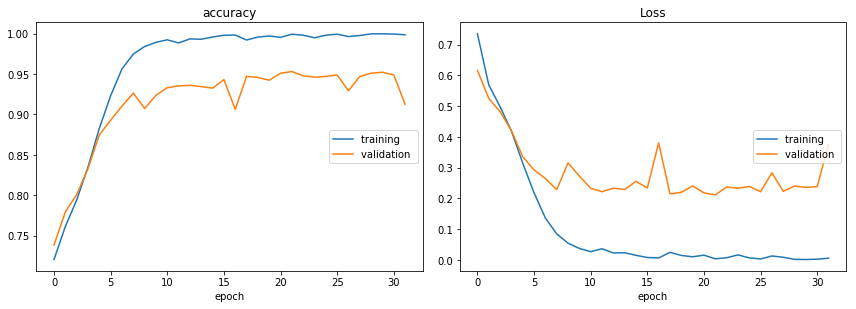

accuracy
	training         	 (min:    0.721, max:    1.000, cur:    0.999)
	validation       	 (min:    0.739, max:    0.953, cur:    0.913)
Loss
	training         	 (min:    0.001, max:    0.736, cur:    0.005)
	validation       	 (min:    0.211, max:    0.616, cur:    0.376)
1056/1056 [==============================] - 54s 51ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.3762 - val_accuracy: 0.9125


In [23]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_train_images), validation_steps = len(imit_test_images),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [24]:
# save model
fname = 'final md td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [25]:
loss, acc = model.evaluate(validation_dataset, steps = len(imit_test_images))
loss, acc

264/264 [==============================] - 9s 34ms/step - loss: 0.2113 - accuracy: 0.9532


(0.21132086217403412, 0.953156590461731)

In [26]:
validation_dataset = data_generator(x3test, y3test)

In [27]:
loss, acc = model.evaluate(validation_dataset, steps = len(x3test))
loss, acc

1551/1551 [==============================] - 10s 6ms/step - loss: 2.2708 - accuracy: 0.6117


(2.270785093307495, 0.6117053627967834)

In [80]:
train_dataset = data_generator(x3train, y3train)
validation_dataset = data_generator(x3test, y3test)

In [83]:
model = tdcnn2d_bilstm_seq(input_shape11)

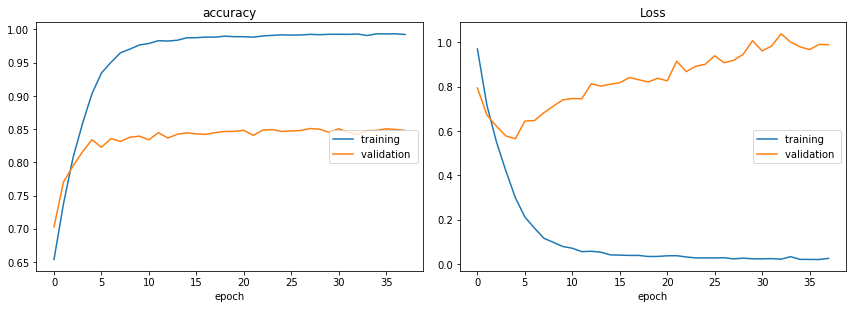

accuracy
	training         	 (min:    0.467, max:    0.993, cur:    0.992)
	validation       	 (min:    0.497, max:    0.904, cur:    0.848)
Loss
	training         	 (min:    0.020, max:    1.922, cur:    0.025)
	validation       	 (min:    0.298, max:    1.995, cur:    0.989)
6202/6202 [==============================] - 80s 13ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.9895 - val_accuracy: 0.8479


In [84]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [85]:
# save model
fname = 'final md gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [86]:
loss, acc = model.evaluate(validation_dataset, steps = len(x3test))
loss, acc

1551/1551 [==============================] - 10s 7ms/step - loss: 0.9188 - accuracy: 0.8508


(0.9188046455383301, 0.8507636785507202)

#### range-Doppler

In [ ]:
filename = 'Datasets/final_imit_RD-RA.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]

In [36]:
print(imit_y_train_RD.shape)
print(imit_y_test_RD.shape)
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

(1056, 605)
(264, 605)
(1056, 120, 64, 64, 3)
(1056, 120, 64, 64, 3)
(264, 120, 64, 64, 3)
(264, 120, 64, 64, 3)


In [62]:
x1train, y1train = masker(imit_RD_train, imit_y_train_RD[:,0:600:5], mask_down_train)
x1test, y1test = masker(imit_RD_test, imit_y_test_RD[:,0:600:5], mask_down_test)
x2train, y1train = masker(imit_RA_train, imit_y_train_RD[:,0:600:5], mask_down_train)
x2test, y1test = masker(imit_RA_test, imit_y_test_RD[:,0:600:5], mask_down_test)
print(x1train.shape)
print(x1test.shape)
print(x2train.shape)
print(x2test.shape)
print(y1train.shape)
print(y1test.shape)

(6202,)
(1551,)
(6202,)
(1551,)
(6202,)
(1551,)


In [39]:
input_shape_rd = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3])
print('Input shape of f-b-f RD: ',input_shape_rd)

Input shape of f-b-f RD:  (None, 64, 64, 3)


In [74]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

In [75]:
train_dataset = data_generator(imit_RD_train, to_categorical(imit_y_train_RD[:,0:600:5],num_classes=num_class))
validation_dataset = data_generator(imit_RD_test, to_categorical(imit_y_test_RD[:,0:600:5],num_classes=num_class))

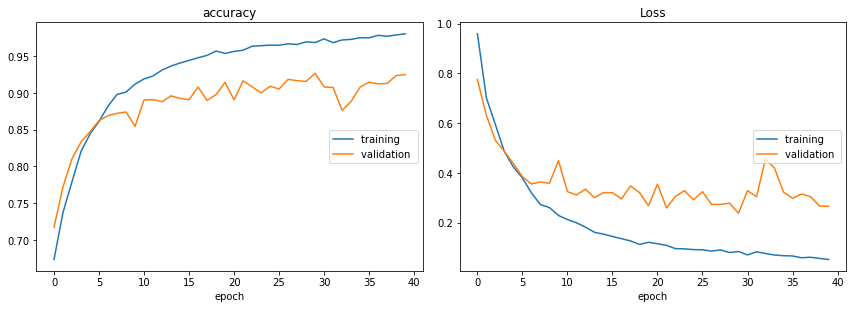

accuracy
	training         	 (min:    0.496, max:    1.000, cur:    0.981)
	validation       	 (min:    0.505, max:    0.953, cur:    0.925)
Loss
	training         	 (min:    0.001, max:    1.845, cur:    0.051)
	validation       	 (min:    0.211, max:    1.754, cur:    0.265)
1056/1056 [==============================] - 23s 22ms/step - loss: 0.0511 - accuracy: 0.9806 - val_loss: 0.2652 - val_accuracy: 0.9249


In [76]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RD_train), validation_steps = len(imit_RD_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [77]:
# save model
fname = 'final rd td2d no gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [78]:
loss, acc = model.evaluate(validation_dataset, steps = len(imit_RD_test))
loss, acc

264/264 [==============================] - 3s 10ms/step - loss: 0.2376 - accuracy: 0.9268


(0.23759202659130096, 0.9267992377281189)

In [79]:
validation_dataset = data_generator(x1test, y1test)

In [80]:
loss, acc = model.evaluate(validation_dataset, steps = len(x1test))
loss, acc

1551/1551 [==============================] - 8s 5ms/step - loss: 9.6594 - accuracy: 0.2418


(9.659419059753418, 0.24181419610977173)

In [81]:
train_dataset = data_generator(x1train, y1train)
validation_dataset = data_generator(x1test, y1test)

In [82]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

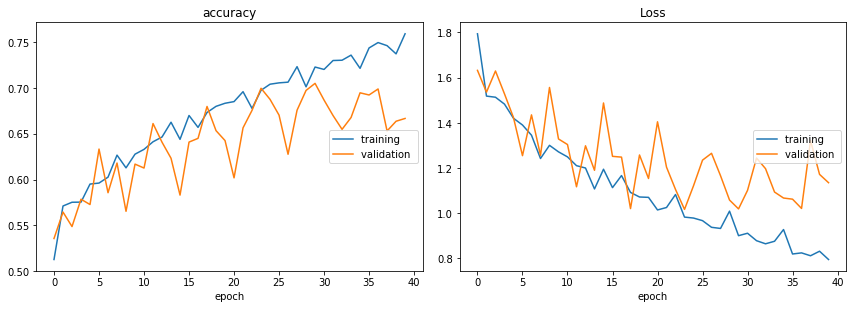

accuracy
	training         	 (min:    0.496, max:    1.000, cur:    0.759)
	validation       	 (min:    0.505, max:    0.953, cur:    0.667)
Loss
	training         	 (min:    0.001, max:    1.845, cur:    0.795)
	validation       	 (min:    0.211, max:    1.754, cur:    1.135)
1056/1056 [==============================] - 13s 12ms/step - loss: 0.7954 - accuracy: 0.7593 - val_loss: 1.1352 - val_accuracy: 0.6668


In [83]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RD_train), validation_steps = len(imit_RD_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [84]:
# save model
fname = 'final rd gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [85]:
loss, acc = model.evaluate(validation_dataset, steps = len(x1test))
loss, acc

1551/1551 [==============================] - 8s 5ms/step - loss: 1.1280 - accuracy: 0.6797


(1.1279712915420532, 0.6797141432762146)

#### range-DOA

In [86]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

In [87]:
train_dataset = data_generator(imit_RA_train, to_categorical(imit_y_train_RD[:,0:600:5],num_classes=num_class))
validation_dataset = data_generator(imit_RA_test, to_categorical(imit_y_test_RD[:,0:600:5],num_classes=num_class))

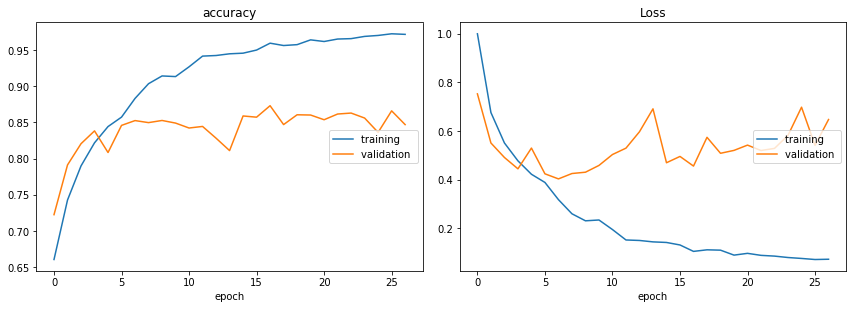

accuracy
	training         	 (min:    0.496, max:    1.000, cur:    0.971)
	validation       	 (min:    0.505, max:    0.953, cur:    0.847)
Loss
	training         	 (min:    0.001, max:    1.845, cur:    0.074)
	validation       	 (min:    0.211, max:    1.754, cur:    0.647)
1056/1056 [==============================] - 24s 22ms/step - loss: 0.0738 - accuracy: 0.9715 - val_loss: 0.6472 - val_accuracy: 0.8469


In [88]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RA_train), validation_steps = len(imit_RA_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [89]:
# save model
fname = 'final ra td2d no gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [90]:
loss, acc = model.evaluate(validation_dataset, steps = len(imit_RA_test))
loss, acc

264/264 [==============================] - 3s 11ms/step - loss: 0.4561 - accuracy: 0.8730


(0.45613545179367065, 0.8729798197746277)

In [91]:
validation_dataset = data_generator(x2test, y1test)

In [92]:
loss, acc = model.evaluate(validation_dataset, steps = len(x2test))
loss, acc

1551/1551 [==============================] - 8s 5ms/step - loss: 8.6168 - accuracy: 0.2852


(8.616809844970703, 0.2852071523666382)

In [93]:
train_dataset = data_generator(x2train, y1train)
validation_dataset = data_generator(x2test, y1test)

In [94]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

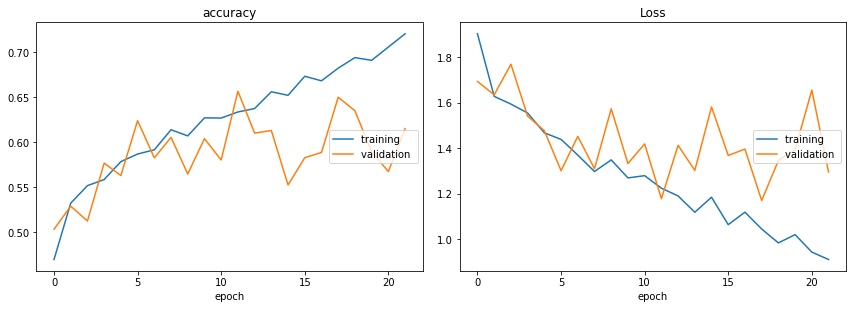

accuracy
	training         	 (min:    0.469, max:    1.000, cur:    0.721)
	validation       	 (min:    0.503, max:    0.953, cur:    0.615)
Loss
	training         	 (min:    0.001, max:    1.903, cur:    0.910)
	validation       	 (min:    0.211, max:    1.769, cur:    1.295)
1056/1056 [==============================] - 13s 12ms/step - loss: 0.9104 - accuracy: 0.7205 - val_loss: 1.2951 - val_accuracy: 0.6150


In [95]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RA_train), validation_steps = len(imit_RA_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [96]:
# save model
fname = 'final ra gd td2d'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [97]:
loss, acc = model.evaluate(validation_dataset, steps = len(x2test))
loss, acc

1551/1551 [==============================] - 8s 5ms/step - loss: 1.3449 - accuracy: 0.6131


(1.344896912574768, 0.6131066083908081)

In [102]:
gnd = [stats.mode(np.argmax(y,-1))[0][0] for y in y1test]
Counter(gnd)

Counter({1: 294,
         0: 187,
         2: 159,
         17: 43,
         18: 51,
         3: 226,
         7: 40,
         16: 47,
         10: 51,
         11: 44,
         12: 41,
         8: 40,
         9: 37,
         4: 42,
         14: 59,
         15: 53,
         5: 46,
         6: 40,
         13: 51})

In [110]:
pred = [stats.mode(np.argmax(np.squeeze(model.predict(next(validation_dataset))),-1))[0] for i in range(len(x2test))]

In [113]:
np.squeeze(np.array(pred)).shape

(1551,)

## RD New

In [23]:
x1test[0].shape

(142, 64, 64, 3)

In [24]:
y1test[0].shape

(142, 19)

In [25]:
input_shape_rd = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3])
print('Input shape of f-b-f RD: ',input_shape_rd)

Input shape of f-b-f RD:  (None, 64, 64, 3)


In [23]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

In [28]:
train_dataset = data_generator(imit_RD_train, to_categorical(imit_y_train_RD,num_classes=num_class))
validation_dataset = data_generator(imit_RD_test, to_categorical(imit_y_test_RD,num_classes=num_class))

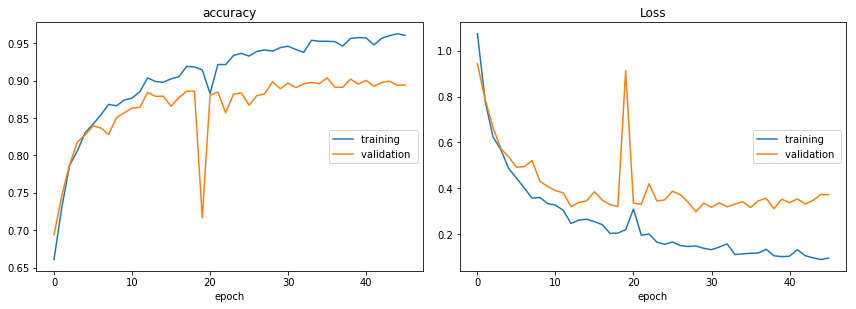

accuracy
	training         	 (min:    0.661, max:    0.962, cur:    0.960)
	validation       	 (min:    0.694, max:    0.904, cur:    0.894)
Loss
	training         	 (min:    0.089, max:    1.074, cur:    0.096)
	validation       	 (min:    0.298, max:    0.943, cur:    0.372)
1056/1056 [==============================] - 85s 80ms/step - loss: 0.0958 - accuracy: 0.9604 - val_loss: 0.3725 - val_accuracy: 0.8940


In [29]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RD_train), validation_steps = len(imit_RD_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [30]:
# save model
fname = 'final rd td2d no gd 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [31]:
loss, acc = model.evaluate(validation_dataset, steps = len(imit_RD_test))
loss, acc

264/264 [==============================] - 13s 51ms/step - loss: 0.3163 - accuracy: 0.9037


(0.31627315282821655, 0.9037064909934998)

In [37]:
validation_dataset = data_generator(x1test, y1test)

In [38]:
loss, acc = model.evaluate(validation_dataset, steps = len(x1test))
loss, acc

1558/1558 [==============================] - 14s 9ms/step - loss: 4.4850 - accuracy: 0.4363


(4.485012531280518, 0.4363093972206116)

In [59]:
train_dataset = data_generator(x1train, y1train)
validation_dataset = data_generator(x1test, y1test)

In [60]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

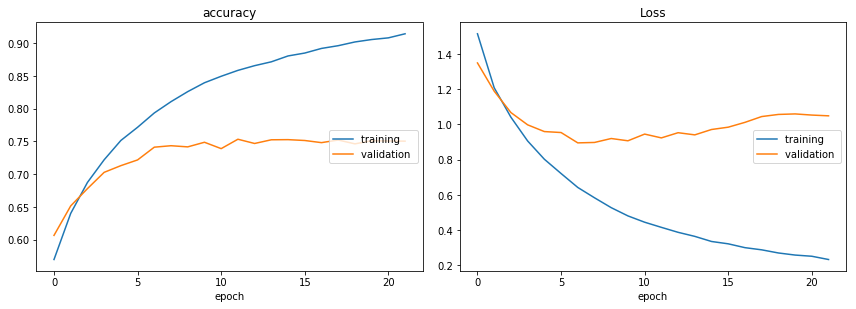

accuracy
	training         	 (min:    0.467, max:    0.962, cur:    0.915)
	validation       	 (min:    0.497, max:    0.904, cur:    0.750)
Loss
	training         	 (min:    0.089, max:    1.922, cur:    0.233)
	validation       	 (min:    0.298, max:    1.808, cur:    1.049)
6250/6250 [==============================] - 108s 17ms/step - loss: 0.2331 - accuracy: 0.9146 - val_loss: 1.0490 - val_accuracy: 0.7504


In [61]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x1train), validation_steps = len(x1test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [62]:
# save model
fname = 'final rd gd td2d 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [63]:
loss, acc = model.evaluate(validation_dataset, steps = len(x1test))
loss, acc

1558/1558 [==============================] - 13s 8ms/step - loss: 0.9237 - accuracy: 0.7534


(0.9236823916435242, 0.7533585429191589)

# RA New

In [44]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

In [45]:
train_dataset = data_generator(imit_RA_train, to_categorical(imit_y_train_RD,num_classes=num_class))
validation_dataset = data_generator(imit_RA_test, to_categorical(imit_y_test_RD,num_classes=num_class))

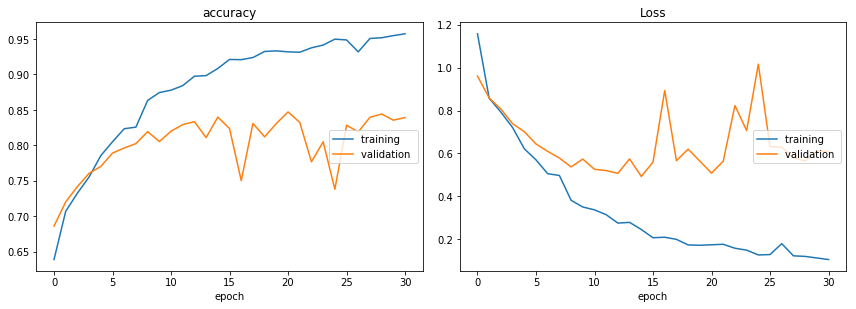

accuracy
	training         	 (min:    0.514, max:    0.962, cur:    0.957)
	validation       	 (min:    0.519, max:    0.904, cur:    0.839)
Loss
	training         	 (min:    0.089, max:    1.809, cur:    0.106)
	validation       	 (min:    0.298, max:    1.726, cur:    0.611)
1056/1056 [==============================] - 83s 78ms/step - loss: 0.1065 - accuracy: 0.9572 - val_loss: 0.6111 - val_accuracy: 0.8391


In [46]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(imit_RD_train), validation_steps = len(imit_RD_test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [47]:
# save model
fname = 'final ra td2d no gd 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [48]:
loss, acc = model.evaluate(validation_dataset, steps = len(imit_RA_test))
loss, acc

264/264 [==============================] - 12s 47ms/step - loss: 0.5085 - accuracy: 0.8470


(0.5085068941116333, 0.8469947576522827)

In [49]:
validation_dataset = data_generator(x2test, y1test)

In [50]:
loss, acc = model.evaluate(validation_dataset, steps = len(x2test))
loss, acc

1558/1558 [==============================] - 13s 8ms/step - loss: 5.6834 - accuracy: 0.3412


(5.683352470397949, 0.34119758009910583)

In [64]:
train_dataset = data_generator(x2train, y1train)
validation_dataset = data_generator(x2test, y1test)

In [65]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

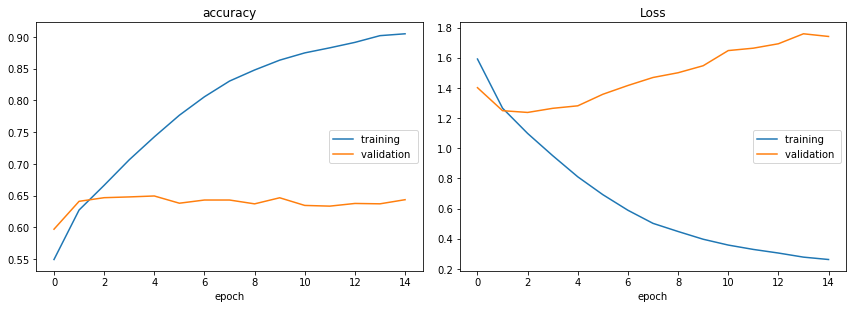

accuracy
	training         	 (min:    0.467, max:    0.962, cur:    0.905)
	validation       	 (min:    0.497, max:    0.904, cur:    0.644)
Loss
	training         	 (min:    0.089, max:    1.922, cur:    0.262)
	validation       	 (min:    0.298, max:    1.808, cur:    1.741)
6250/6250 [==============================] - 108s 17ms/step - loss: 0.2620 - accuracy: 0.9049 - val_loss: 1.7415 - val_accuracy: 0.6437


In [66]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x2train), validation_steps = len(x2test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [67]:
# save model
fname = 'final ra gd td2d 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [68]:
loss, acc = model.evaluate(validation_dataset, steps = len(x2test))
loss, acc

1558/1558 [==============================] - 13s 8ms/step - loss: 1.2814 - accuracy: 0.6496


(1.28139066696167, 0.6495895385742188)

## Eliminate zeros

In [69]:
train_dataset = data_generator(x4train, y4train)
validation_dataset = data_generator(x4test, y4test)

In [70]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

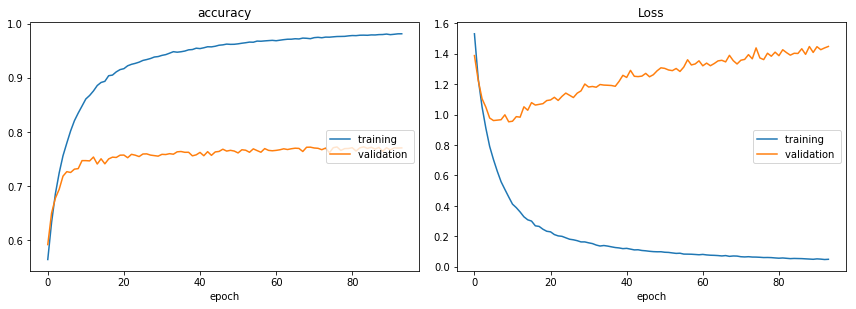

accuracy
	training         	 (min:    0.467, max:    0.981, cur:    0.981)
	validation       	 (min:    0.497, max:    0.904, cur:    0.770)
Loss
	training         	 (min:    0.047, max:    1.922, cur:    0.048)
	validation       	 (min:    0.298, max:    1.808, cur:    1.448)
5666/5666 [==============================] - 96s 17ms/step - loss: 0.0485 - accuracy: 0.9813 - val_loss: 1.4483 - val_accuracy: 0.7704


In [71]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x4train), validation_steps = len(x4test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [72]:
# save model
fname = 'final rd gd td2d no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [73]:
loss, acc = model.evaluate(validation_dataset, steps = len(x4test))
loss, acc

1403/1403 [==============================] - 12s 8ms/step - loss: 1.3911 - accuracy: 0.7723


(1.3910729885101318, 0.7723276615142822)

In [75]:
train_dataset = data_generator(x5train, y4train)
validation_dataset = data_generator(x5test, y4test)

In [76]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

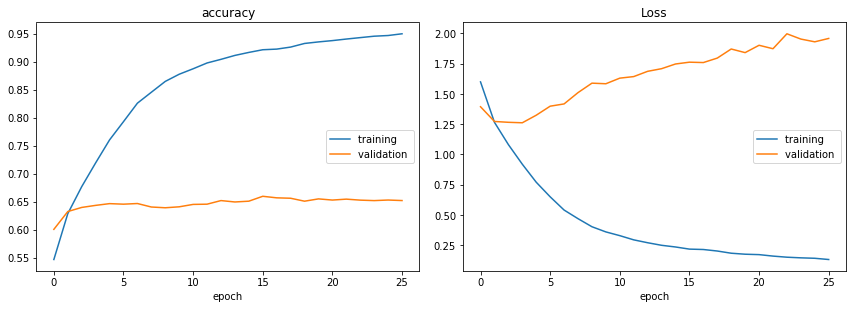

accuracy
	training         	 (min:    0.467, max:    0.981, cur:    0.950)
	validation       	 (min:    0.497, max:    0.904, cur:    0.652)
Loss
	training         	 (min:    0.047, max:    1.922, cur:    0.133)
	validation       	 (min:    0.298, max:    1.995, cur:    1.957)
5666/5666 [==============================] - 95s 17ms/step - loss: 0.1332 - accuracy: 0.9496 - val_loss: 1.9569 - val_accuracy: 0.6518


In [77]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x5train), validation_steps = len(x5test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [78]:
# save model
fname = 'final ra gd td2d no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [79]:
loss, acc = model.evaluate(validation_dataset, steps = len(x5test))
loss, acc

1403/1403 [==============================] - 11s 8ms/step - loss: 1.7610 - accuracy: 0.6594


(1.7609851360321045, 0.6593899130821228)

In [88]:
train_dataset = data_generator(x6train, y6train)
validation_dataset = data_generator(x6test, y6test)

In [89]:
model = tdcnn2d_bilstm_seq(input_shape_rd)

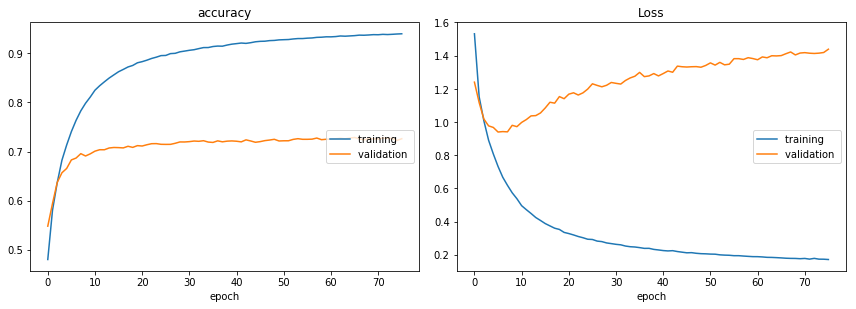

accuracy
	training         	 (min:    0.467, max:    0.993, cur:    0.940)
	validation       	 (min:    0.497, max:    0.904, cur:    0.726)
Loss
	training         	 (min:    0.020, max:    1.922, cur:    0.171)
	validation       	 (min:    0.298, max:    1.995, cur:    1.439)
5750/5750 [==============================] - 77s 13ms/step - loss: 0.1712 - accuracy: 0.9400 - val_loss: 1.4389 - val_accuracy: 0.7262


In [90]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x6train), validation_steps = len(x6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [91]:
# save model
fname = 'final md gd td2d no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [92]:
loss, acc = model.evaluate(validation_dataset, steps = len(x6test))
loss, acc

1425/1425 [==============================] - 8s 6ms/step - loss: 1.4003 - accuracy: 0.7287


(1.400330901145935, 0.728692889213562)

# Reshape

In [30]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 64, 64, 3)


In [28]:
def tdcnn3d_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1, 2, 2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [96]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

In [97]:
# rd
train_dataset = data_generator(x_train11, y_train11)
validation_dataset = data_generator(x_test11, y_test11)

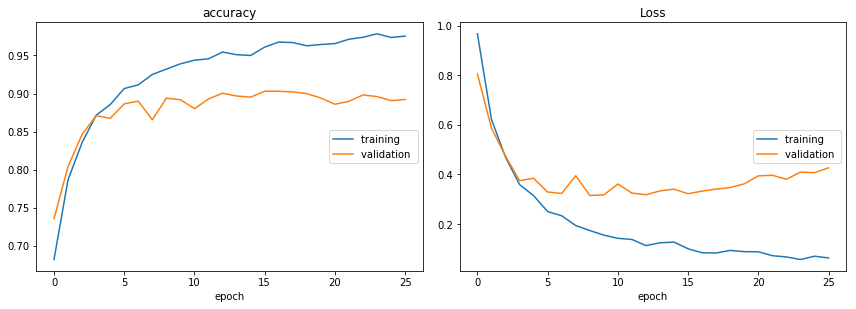

accuracy
	training         	 (min:    0.467, max:    0.993, cur:    0.975)
	validation       	 (min:    0.497, max:    0.904, cur:    0.892)
Loss
	training         	 (min:    0.020, max:    1.922, cur:    0.062)
	validation       	 (min:    0.298, max:    1.995, cur:    0.426)
1056/1056 [==============================] - 64s 61ms/step - loss: 0.0625 - accuracy: 0.9755 - val_loss: 0.4263 - val_accuracy: 0.8921


In [98]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x_train11), validation_steps = len(x_test11),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [99]:
# save model
fname = 'final rd td3d res'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [100]:
loss, acc = model.evaluate(validation_dataset, steps = len(x_test11))
loss, acc

264/264 [==============================] - 11s 42ms/step - loss: 0.3217 - accuracy: 0.9031


(0.3216829299926758, 0.9030618667602539)

In [143]:
validation_dataset = data_generator(x8test, y8test)

In [144]:
y8test[2].shape

(33, 19)

In [145]:
loss, acc = model.evaluate(validation_dataset, steps = len(x8test))
loss, acc

1551/1551 [==============================] - 11s 7ms/step - loss: 1.2895 - accuracy: 0.7206


(1.289499282836914, 0.7205848097801208)

In [146]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

In [147]:
# ra
train_dataset = data_generator(x_train12, y_train11)
validation_dataset = data_generator(x_test12, y_test11)

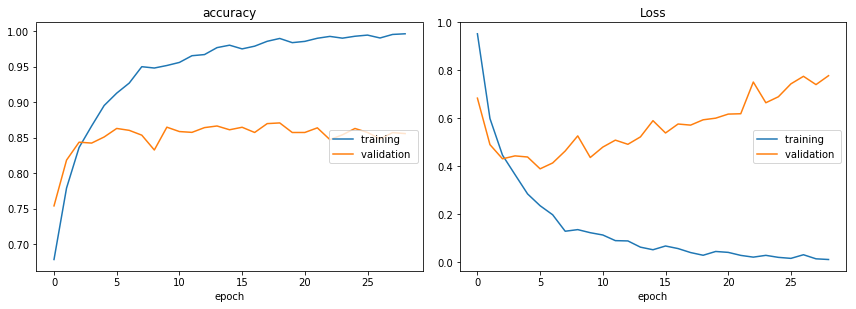

accuracy
	training         	 (min:    0.467, max:    0.997, cur:    0.997)
	validation       	 (min:    0.497, max:    0.904, cur:    0.856)
Loss
	training         	 (min:    0.010, max:    1.922, cur:    0.011)
	validation       	 (min:    0.298, max:    2.530, cur:    0.777)
1056/1056 [==============================] - 65s 62ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.7774 - val_accuracy: 0.8557


In [148]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x_train12), validation_steps = len(x_test12),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [149]:
# save model
fname = 'final ra td3d res'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [150]:
loss, acc = model.evaluate(validation_dataset, steps = len(x_test12))
loss, acc

264/264 [==============================] - 12s 46ms/step - loss: 0.5936 - accuracy: 0.8708


(0.5935773253440857, 0.8707702159881592)

In [152]:
validation_dataset = data_generator(x9test, y8test)

In [153]:
loss, acc = model.evaluate(validation_dataset, steps = len(x8test))
loss, acc

1551/1551 [==============================] - 11s 7ms/step - loss: 8.9261 - accuracy: 0.2658


(8.926116943359375, 0.2657760679721832)

In [154]:
# rd
train_dataset = data_generator(x8train, y8train)
validation_dataset = data_generator(x8test, y8test)

In [155]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

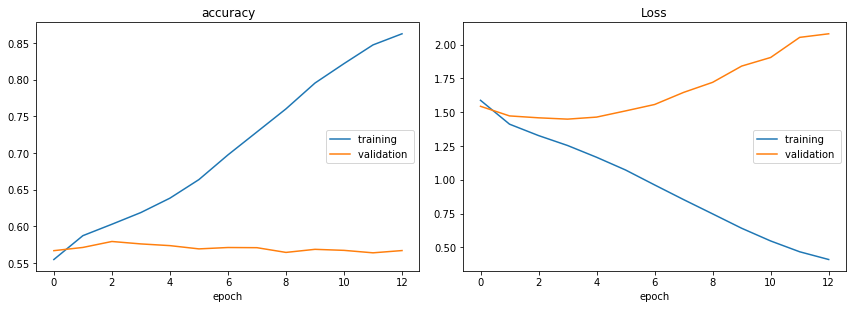

accuracy
	training         	 (min:    0.467, max:    0.997, cur:    0.863)
	validation       	 (min:    0.497, max:    0.904, cur:    0.567)
Loss
	training         	 (min:    0.010, max:    1.922, cur:    0.410)
	validation       	 (min:    0.298, max:    2.530, cur:    2.080)
6202/6202 [==============================] - 99s 16ms/step - loss: 0.4101 - accuracy: 0.8626 - val_loss: 2.0802 - val_accuracy: 0.5670


In [156]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x8train), validation_steps = len(x8test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [157]:
# save model
fname = 'final rd gd td3d res'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [158]:
loss, acc = model.evaluate(validation_dataset, steps = len(x8test))
loss, acc

1551/1551 [==============================] - 10s 6ms/step - loss: 1.4585 - accuracy: 0.5793


(1.4585031270980835, 0.5793358087539673)

In [159]:
# ra
train_dataset = data_generator(x9train, y8train)
validation_dataset = data_generator(x9test, y8test)

In [160]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

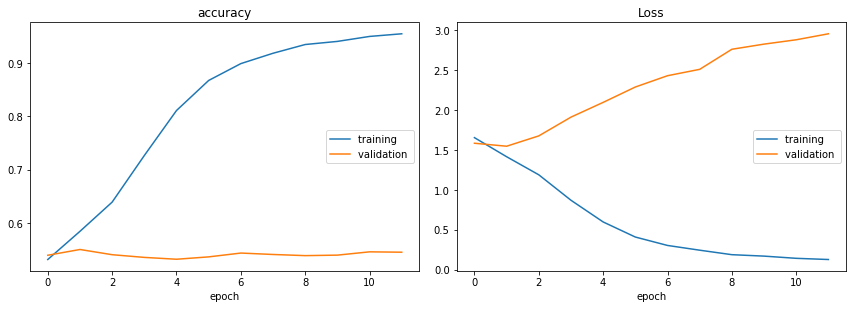

accuracy
	training         	 (min:    0.467, max:    0.997, cur:    0.954)
	validation       	 (min:    0.497, max:    0.904, cur:    0.545)
Loss
	training         	 (min:    0.010, max:    1.922, cur:    0.125)
	validation       	 (min:    0.298, max:    2.958, cur:    2.958)
6202/6202 [==============================] - 100s 16ms/step - loss: 0.1254 - accuracy: 0.9545 - val_loss: 2.9583 - val_accuracy: 0.5454


In [161]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x8train), validation_steps = len(x9test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [162]:
# save model
fname = 'final ra gd td3d res'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [163]:
loss, acc = model.evaluate(validation_dataset, steps = len(x9test))
loss, acc

1551/1551 [==============================] - 11s 7ms/step - loss: 1.5472 - accuracy: 0.5505


(1.5471889972686768, 0.5505161285400391)

In [165]:
# rd
train_dataset = data_generator(x10train, y10train)
validation_dataset = data_generator(x10test, y10test)

In [166]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

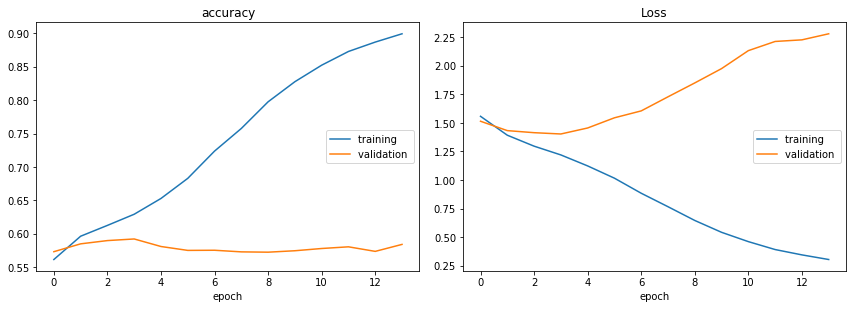

accuracy
	training         	 (min:    0.467, max:    0.997, cur:    0.899)
	validation       	 (min:    0.497, max:    0.904, cur:    0.584)
Loss
	training         	 (min:    0.010, max:    1.922, cur:    0.304)
	validation       	 (min:    0.298, max:    2.958, cur:    2.279)
5750/5750 [==============================] - 93s 16ms/step - loss: 0.3040 - accuracy: 0.8994 - val_loss: 2.2793 - val_accuracy: 0.5841


In [167]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [168]:
# save model
fname = 'final rd gd td3d res no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [169]:
loss, acc = model.evaluate(validation_dataset, steps = len(x10test))
loss, acc

1379/1379 [==============================] - 9s 7ms/step - loss: 1.4025 - accuracy: 0.5922


(1.4025264978408813, 0.5922467708587646)

In [170]:
# ra
train_dataset = data_generator(x11train, y10train)
validation_dataset = data_generator(x11test, y10test)

In [171]:
model = tdcnn3d_bilstm_seq(input_shape_vid)

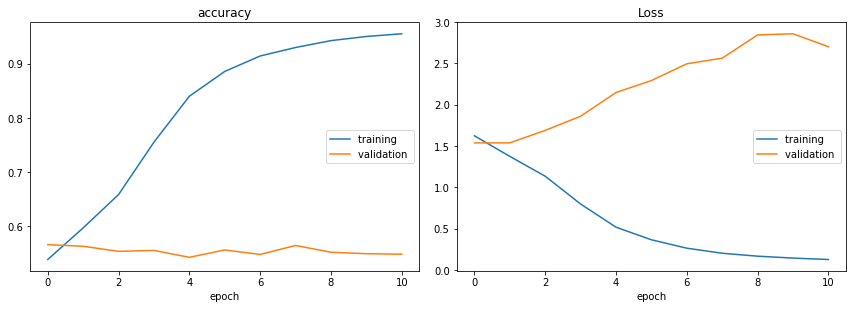

accuracy
	training         	 (min:    0.467, max:    0.997, cur:    0.955)
	validation       	 (min:    0.497, max:    0.904, cur:    0.548)
Loss
	training         	 (min:    0.010, max:    1.922, cur:    0.127)
	validation       	 (min:    0.298, max:    2.958, cur:    2.702)
6202/6202 [==============================] - 98s 16ms/step - loss: 0.1272 - accuracy: 0.9555 - val_loss: 2.7025 - val_accuracy: 0.5476


In [172]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x8train), validation_steps = len(x9test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [173]:
# save model
fname = 'final ra gd td3d res no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [174]:
loss, acc = model.evaluate(validation_dataset, steps = len(x11test))
loss, acc

1379/1379 [==============================] - 9s 7ms/step - loss: 1.5450 - accuracy: 0.5637


(1.5450372695922852, 0.5637097954750061)

# Fusion

In [34]:
fname = 'final md gd td2d no zeros'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json)
model_md.load_weights(w_file)

In [35]:
fname = 'final rd gd td3d res no zeros'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json)
model_rd.load_weights(w_file)

In [36]:
fname = 'final ra gd td3d res no zeros'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json)
model_ra.load_weights(w_file)

In [38]:
def data_generator_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
#             asldaily = labels[1][offset:offset+batch_size]
#             twohand = labels[2][offset:offset+batch_size]
#             major = labels[3][offset:offset+batch_size]
#             move = labels[4][offset:offset+batch_size]
#             stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
#             y_train2 = []
#             y_train3 = []
#             y_train4 = []
#             y_train5 = []
#             y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(label[i])
#                 y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train2.append(asldaily[i])
#                 y_train3.append(twohand[i])
#                 y_train4.append(major[i])
#                 y_train5.append(move[i])
#                 y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
#             y_train2 = np.array(y_train2)
#             y_train3 = np.array(y_train3)
#             y_train4 = np.array(y_train4)
#             y_train5 = np.array(y_train5)
#             y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3], y_train

In [39]:
train_dataset = data_generator_multi([x10train, x11train, x6train], [y6train])
validation_dataset = data_generator_multi([x10test, x11test, x6test], [y6test])

In [99]:
x10train[0].shape

(25, 5, 64, 64, 3)

In [100]:
md_pool = Reshape((-1,256//4))(model_md.layers[-2].output)
md_pool = model_md.layers[-2].output
# md_pool = MaxPooling1D((2))(md_pool)

In [103]:
merged_layers = concatenate([model_rd.layers[-2].output,model_ra.layers[-2].output,md_pool])
out1 = Dense(num_class,activation='softmax')(merged_layers)
model = keras.Model(inputs = [model_rd.input,model_ra.input,model_md.input],outputs = out1)#, out2, out3])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

Epoch 1/100
   2/5750 [..............................] - ETA: 6:36 - loss: 1.1921e-07 - accuracy: 0.3462

### didn't work...

In [40]:
def multi_mod():
    with tf.device('/gpu:2'):
        
        inputlayer1 = Input(shape = input_shape_vid)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Flatten())(y)
        y = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(y)
        
        inputlayer2 = Input(shape = input_shape_vid)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer2)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Flatten())(z)
        z = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(z)
        
        inputlayer3 = Input(shape = input_shape11)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        cat = concatenate([y,z,x])
        out = TimeDistributed(Dense(num_class,activation='softmax'))(cat)
        
        model = keras.Model(inputs = [inputlayer1,inputlayer2,inputlayer3], outputs = [out])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        
        return model 

In [41]:
model = multi_mod()

In [ ]:
train_dataset = data_generator_multi([x10train, x11train, x6train], [y6train])
validation_dataset = data_generator_multi([x10test, x11test, x6test], [y6test])

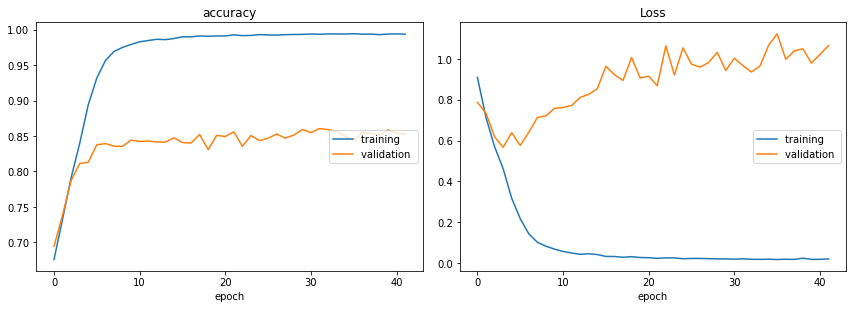

accuracy
	training         	 (min:    0.676, max:    0.994, cur:    0.994)
	validation       	 (min:    0.694, max:    0.860, cur:    0.852)
Loss
	training         	 (min:    0.017, max:    0.910, cur:    0.020)
	validation       	 (min:    0.567, max:    1.124, cur:    1.066)
6202/6202 [==============================] - 215s 35ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 1.0658 - val_accuracy: 0.8524


In [43]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [44]:
# save model
fname = 'final multi gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [53]:
loss, acc = model.evaluate(validation_dataset, steps = len(x11test))
loss, acc

1425/1425 [==============================] - 22s 16ms/step - loss: 0.9584 - accuracy: 0.8609


(0.9583634734153748, 0.8608629703521729)

# CTC

In [34]:
y_int_train = np.array([np.argmax(y,-1) for y in y6train])
y_int_test = np.array([np.argmax(y,-1) for y in y6test])

In [35]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

In [36]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [37]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y6train]
ctc_ts3 = [num_to_ch(y) for y in y6test]
print(ctc_tr3[0])
ctc_tr1 = [num_to_ch(y) for y in y10train]
ctc_ts1 = [num_to_ch(y) for y in y10test]
print(ctc_tr1[0])

AAABBBBBBBBBBBBBBBBBBBBBB
AABBBBBBBBBBBBBBBBBBBBBBB


In [38]:
# convert detected labels
ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6train]
ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6test]
# ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6train]
# ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6test]
print(ctc_tr4[0])
ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10train]
ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10test]
# ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10train]
# ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10test]
print(ctc_tr2[0])

BBBBBBBBBBBBBBBBBBBBBBBBB
BBBBBBBBBBBBBBBBBBBBBBBBB


In [39]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [40]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True)

In [41]:
def data_generator_multi_md(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
#             yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
            yield [X_train3, y_train], y_train

In [42]:
def data_generator_multi_nolabel_md(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

In [74]:
train_dataset = data_generator_multi_md([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x10test, x11test, x6test])

In [75]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred          

In [85]:
def ctc_md3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
#         new_shape = (-1, (128//2**3) *64)
        new_shape = (-1, 16*16*8//2) ## keeping time dim long increases the training time
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [86]:
model = ctc_md3()

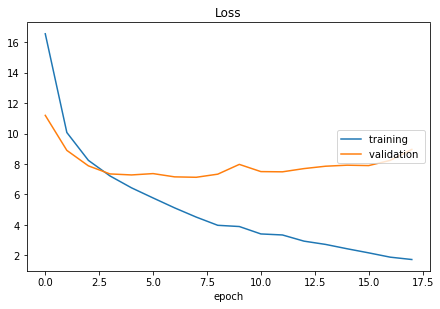

Loss
	training         	 (min:    1.725, max:      inf, cur:    1.725)
	validation       	 (min:    7.125, max:      inf, cur:    8.956)
5750/5750 [==============================] - 90s 16ms/step - loss: 1.7251 - val_loss: 8.9564


In [87]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x6train), validation_steps = len(x6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [88]:
# save model
fname = 'final ctc md gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [89]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [90]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [91]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAAADDDDDDDD


In [92]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBCCCCCCCCC | BBBBBBBBBBBBBBBBBBBBCCCCCCCCC :Original
2. Predicted: AEEEEEEE | AEEEEEEE :Original
3. Predicted: AAAAADDDDDDDD | AAAADDDDDDDD :Original
4. Predicted: AAABBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBB :Original
5. Predicted: BBBBBBBBBBBCC | BBBBBBBBBBBCC :Original
6. Predicted: CCCCCCCCCAAA | CCCCCCCCCAAA :Original
7. Predicted: OOOOOROOOROR | IIIIIIIIIIAA :Original
8. Predicted: AJJJPJJJJJPA | JJJJJJJJJJAA :Original
9. Predicted: DDDDDDDDDD | DDDDDDDDDD :Original
10. Predicted: BBBBBBBBBBBBBCCCCCCCCCC | BBBBBBBBBBBBBCCCCCCCCCC :Original
11. Predicted: AAEEEEEEE | AAEEEEEEE :Original
12. Predicted: EEEQA | EEEEE :Original
13. Predicted: AFFFFFFFFFFFAAAAAAAAAGGGGGGGGGGG | AFFFFFFFFFFFAAAAAAAAAGGGGGGGGGGG :Original
14. Predicted: ADDDDDDDDDDD | ADDDDDDDDDD :Original
15. Predicted: BBBBBBBBBB | BBBBBBBBBB :Original
16. Predicted: BCCCCCCCC | BCCCCCCCC :Original
17. Predicted: AAAQQQQQQQQQ | AAAQQQQQQQQQ :Original
18. Predicted: AAAARRRRRRRR | AAAARRRR

1375. Predicted: IIIIIIIIIAAAA | IIIIIIIIIAAAA :Original
1376. Predicted: AMJMJJJJJ | JJJJJJJJJ :Original
1377. Predicted: AAADDDDDDDDD | AAADDDDDDDDD :Original
1378. Predicted: AABBBBBB | AABBBBBB :Original
1379. Predicted: BBBBBBBBBBBBBBBBBBBC | BBBBBBBBBBBBBBBBBBBB :Original
1380. Predicted: AAAAAQQQQQQQQQQQ | AAAAAAQQQQQQQQQQ :Original
1381. Predicted: AAAARRRRRRRRRRR | AAAAARRRRRRRRRR :Original
1382. Predicted: AAAASSSSSSSSSSS | AAAASSSSSSSSSSS :Original
1383. Predicted: AAADDDDDDDDD | AAAAADDDDDDD :Original
1384. Predicted: AAABBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBBBBB :Original
1385. Predicted: BBBBBBBBBCCCCCCCCCCCAAA | BBBBBBBBBCCCCCCCCCCCAAA :Original
1386. Predicted: KQQQQQQQQQA | QQQQQQQQQQA :Original
1387. Predicted: RRRRRRRRRRRRAAAA | ARRRRRRRRRRRAAAA :Original
1388. Predicted: AAASSSSSSSSSSSSA | AASSSSSSSSSSSSA :Original
1389. Predicted: AAAADDDDDDDDDD | AAAADDDDDDDDDD :Original
1390. Predicted: BBBBBBBBBBBBBBCCCCCCCCCC | BBBBBBBBBBBBBBCCCCCCCCCC :Original
1391. Predicted

In [93]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [94]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

74.66666666666667

### RD

In [53]:
def ctc_rd3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
#         x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
        new_shape = (-1, (64//2**3)*5*8)
#         new_shape = (-1,  8*8*64)
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [54]:
model = ctc_rd3()

In [55]:
train_dataset = data_generator_multi_md([x11train, x6train, x10train], 
                                     [ctc_tr1, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x11test, x6test, x10test], 
                                     [ctc_ts1, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x11test, x6test, x10test])

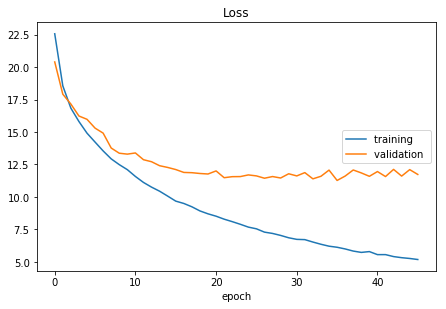

Loss
	training         	 (min:    5.182, max:      inf, cur:    5.182)
	validation       	 (min:   11.270, max:      inf, cur:   11.732)
5750/5750 [==============================] - 146s 25ms/step - loss: 5.1822 - val_loss: 11.7324


In [56]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [57]:
# save model
fname = 'final ctc rd gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [58]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [59]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x10test))]

In [60]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAADDDDDDDDD


In [61]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [62]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts1]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [63]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts1)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

75.50877192982456

### RA

In [64]:
model = ctc_rd3()

In [65]:
train_dataset = data_generator_multi_md([x10train, x6train, x11train], 
                                     [ctc_tr1, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x10test, x6test, x11test], 
                                     [ctc_ts1, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x10test, x6test, x11test])

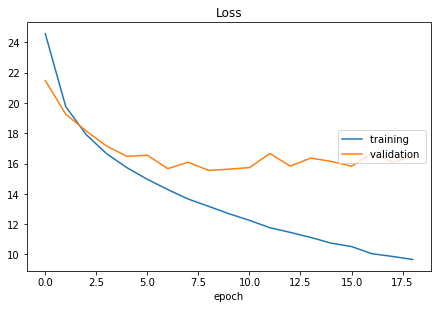

Loss
	training         	 (min:    5.182, max:      inf, cur:    9.663)
	validation       	 (min:   11.270, max:      inf, cur:   16.441)
5750/5750 [==============================] - 147s 26ms/step - loss: 9.6633 - val_loss: 16.4407


In [66]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [67]:
# save model
fname = 'final ctc ra gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [68]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [69]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [70]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AADDDDDDD


In [71]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [72]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts1]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [73]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

65.6140350877193

### Fusion

In [107]:
def ctc_multi():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         new_shape = (-1, (128//2**4) *64*4)
#         new_shape = (-1, 16*16*8//2)
#         new_shape = (-1, (128//2*3)*4*8) ## keeping time dim long increases the training time
        new_shape = (-1, 16*16*8//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(5,1,1)))(y)
#         new_shape2 = (-1, (128//2**4) *64*5)
#         new_shape2 = (-1, 8*8*64)
        new_shape2 = (-1, (64//2**3)*5*8)
        cnv2 = Reshape(target_shape=new_shape2)(y)
#         cnv2 = Dense(64, activation="relu")(cnv2)
#         cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv2)
    
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer2)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
#         z = TimeDistributed(MaxPooling3D(pool_size=(5,1,1)))(z)
#         new_shape3 = (-1, (128//2**4) *64*5)
#         new_shape3 = (-1, 8*8*64)
        new_shape3 = (-1, (64//2**3)*5*8)
        cnv3 = Reshape(target_shape=new_shape3)(z)
#         cnv3 = Dense(64, activation="relu")(cnv3)
#         cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3])
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, labels], outputs = [out_ctc], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt)
        
        return model

In [108]:
def data_generator_multi_ctc(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
#             yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
            yield [X_train1, X_train2, X_train3, y_train], y_train
#             yield [X_train3, y_train], y_train

In [109]:
def data_generator_multi_nolabel_ctc(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [110]:
train_dataset = data_generator_multi_ctc([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_ctc([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_ctc([x10test, x11test, x6test])

In [111]:
model = ctc_multi()

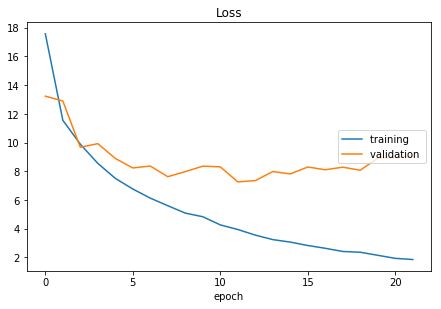

Loss
	training         	 (min:    1.725, max:      inf, cur:    1.848)
	validation       	 (min:    7.125, max:      inf, cur:    9.052)
5750/5750 [==============================] - 344s 60ms/step - loss: 1.8482 - val_loss: 9.0517


In [112]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [113]:
# save model
fname = 'final ctc multi gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [114]:
#### Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [115]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [116]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAAAADDDDDD


In [117]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [118]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [119]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

75.36842105263158

# CTC + MTL

In [121]:
def data_generator_mtl(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [122]:
def data_generator_mtl_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

### mD

In [185]:
train_dataset = data_generator_mtl([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x10test, x11test, x6test])

In [195]:
def ctc_md_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
        
#         new_shape = (-1, (128//2**3) *64)
#         new_shape = (-1, 16*16*64//2)
        new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(32, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [198]:
model = ctc_md_mtl()

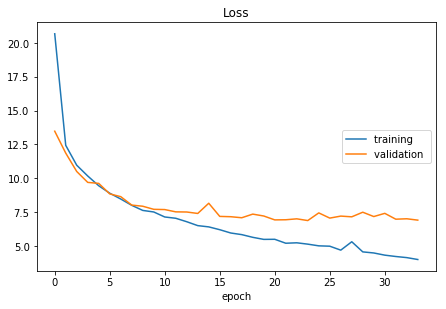

Loss
	training         	 (min:    1.725, max:      inf, cur:    3.992)
	validation       	 (min:    6.870, max:      inf, cur:    6.901)
5750/5750 [==============================] - 93s 16ms/step - loss: 3.9916 - val_loss: 6.9014


In [199]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x6train), validation_steps = len(x6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [127]:
# save model
fname = 'final ctc mtl md gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [128]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [129]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [130]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAADDDDDDDD


In [131]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [132]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [133]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

68.56140350877193

### RD

In [134]:
def ctc_rd_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
#         x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        
#         new_shape = (-1, (128//2**4)*64)
#         new_shape = (-1, 8*8*64)
        new_shape = (-1, (64//2**3)*5*8)
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [135]:
train_dataset = data_generator_mtl([x6train, x11train, x10train], 
                                     [ctc_tr1, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x11test, x10test], 
                                     [ctc_ts1, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x11test, x10test])

In [136]:
model = ctc_rd_mtl()

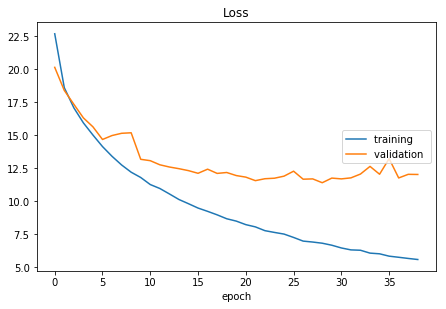

Loss
	training         	 (min:    1.725, max:      inf, cur:    5.555)
	validation       	 (min:    7.125, max:      inf, cur:   12.006)
5750/5750 [==============================] - 147s 26ms/step - loss: 5.5552 - val_loss: 12.0062


In [137]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [138]:
# save model
fname = 'final ctc mtl rd gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [139]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [140]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x10test))]

In [141]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAADDDDDDDD


In [142]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [143]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts1]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [144]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

46.73684210526316

### RA

In [145]:
train_dataset = data_generator_mtl([x6train, x10train, x11train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x10test, x11test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x10test, x11test])

In [146]:
model = ctc_rd_mtl()

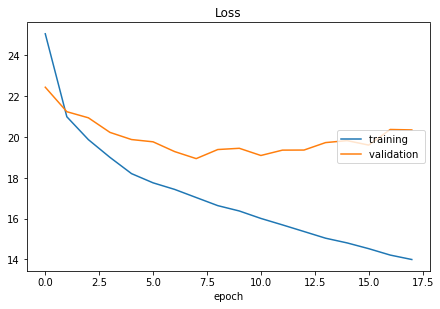

Loss
	training         	 (min:    1.725, max:      inf, cur:   13.995)
	validation       	 (min:    7.125, max:      inf, cur:   20.349)
5750/5750 [==============================] - 146s 25ms/step - loss: 13.9954 - val_loss: 20.3491


In [147]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x11train), validation_steps = len(x11test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [148]:
# save model
fname = 'final ctc mtl ra gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [149]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [150]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [151]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAADDDDDDDD


In [152]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [161]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts1]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [162]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

50.31578947368421

### Fusion

In [155]:
def data_generator_mtl_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [156]:
def data_generator_mtl_nolabel_multi(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [164]:
train_dataset = data_generator_mtl_multi([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl_multi([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel_multi([x10test, x11test, x6test])

In [168]:
def ctc_mtl_multi():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         new_shape = (-1, (128//2**4) *64*4)
#         new_shape = (-1, 16*16*64//2)
        new_shape = (-1, 16*16*8//8)
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(5,1,1)))(y)
#         new_shape2 = (-1, (128//2**4)*64*5)
#         new_shape2 = (-1, 8*8*64)
        new_shape2 = (-1, (64//2**3)*5*8)
        cnv2 = Reshape(target_shape=new_shape2)(y)
#         cnv2 = Dense(64, activation="relu")(cnv2)
#         cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv2)
    
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer2)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
#         new_shape3 = (-1, (128//2**4)*64*5)
#         new_shape3 = (-1, 8*8*64)
        new_shape3 = (-1, (64//2**3)*5*8)
        cnv3 = Reshape(target_shape=new_shape3)(z)
#         cnv3 = Dense(64, activation="relu")(cnv3)
#         cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv3)
        
        concat = concatenate([cnv1,cnv2,cnv3])
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(concat)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(concat)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(concat)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(concat)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(concat)
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [169]:
model = ctc_mtl_multi()

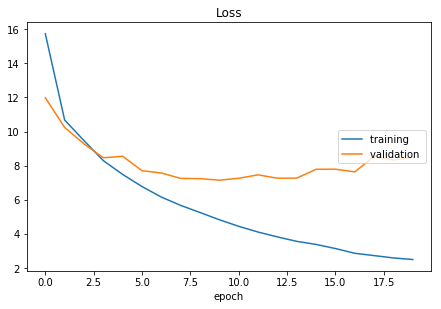

Loss
	training         	 (min:    1.725, max:      inf, cur:    2.487)
	validation       	 (min:    7.125, max:      inf, cur:    8.477)
5750/5750 [==============================] - 348s 61ms/step - loss: 2.4866 - val_loss: 8.4775


In [170]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x6train), validation_steps = len(x6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [171]:
# save model
fname = 'final ctc mtl multi gd no zeros'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [172]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [173]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [174]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAAAADDDDDD


In [175]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBCCCCCCCCC | BBBBBBBBBBBBBBBBBBBBCCCCCCCCC :Original
2. Predicted: AAEEEEEE | AEEEEEEE :Original
3. Predicted: AAAAAADDDDDD | AAAADDDDDDDD :Original
4. Predicted: AAABBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBB :Original
5. Predicted: BBBBBBBBBBBCC | BBBBBBBBBBBCC :Original
6. Predicted: CCCCCCCCCAAA | CCCCCCCCCAAA :Original
7. Predicted: IIIIIIIIIIAR | IIIIIIIIIIAA :Original
8. Predicted: JJPJJJSSSSAA | JJJJJJJJJJAA :Original
9. Predicted: DDDDDDDDDD | DDDDDDDDDD :Original
10. Predicted: BBBBBBBBBBBBBCCCCCCCCCC | BBBBBBBBBBBBBCCCCCCCCCC :Original
11. Predicted: AAEEEEEEE | AAEEEEEEE :Original
12. Predicted: HAAAA | EEEEE :Original
13. Predicted: AFFFFFFFFFFFAAAAAAAAAGGGGGGGGGGG | AFFFFFFFFFFFAAAAAAAAAGGGGGGGGGGG :Original
14. Predicted: ADDDDDDDDDD | ADDDDDDDDDD :Original
15. Predicted: BBBBBBBBBB | BBBBBBBBBB :Original
16. Predicted: BCCCCCCCC | BCCCCCCCC :Original
17. Predicted: AAAQQQHQQQQQ | AAAQQQQQQQQQ :Original
18. Predicted: AAAARRRRRRRR | AAAARRRRRR

In [176]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [177]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

75.9298245614035